In [107]:
import os
os.environ['OMP_NUM_THREADS'] = '2'
os.environ['export OPENBLAS_NUM_THREADS']='2'

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from utilities3 import *

import operator
from functools import reduce
from functools import partial

from timeit import default_timer

from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)

In [108]:
################################################################
# fourier layer
################################################################

class SpectralConv2d_fast(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d_fast, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=64, y=64, c=12)
        output: the solution of the next timestep
        output shape: (batchsize, x=64, y=64, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(12, self.width)
        # input channel is 12: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)

        self.conv0 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm2d(self.width)
        self.bn1 = torch.nn.BatchNorm2d(self.width)
        self.bn2 = torch.nn.BatchNorm2d(self.width)
        self.bn3 = torch.nn.BatchNorm2d(self.width)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        # x = F.pad(x, [0,self.padding, 0,self.padding]) # pad the domain if input is non-periodic
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [109]:
################################################################
# configs
################################################################
DATA_PATH = 'Solutions/acc_rate_data.npy'

# currently data are 41 samples
ntrain = 30
ntest = 10

modes = 12
width = 20

batch_size = 10

epochs = 10 #500
learning_rate = 0.001
scheduler_step = 100
scheduler_gamma = 0.5

print(epochs, learning_rate, scheduler_step, scheduler_gamma)

path = 'ice_inverse_ep100'
path_model = 'model/'+path
path_train_err = 'results/'+path+'train.txt'
path_test_err = 'results/'+path+'test.txt'
path_image = 'image/'+path

S1 = 65
S2 = 97
T_in = 10
T = 10
step = 1

10 0.001 100 0.5


In [110]:
################################################################
# load data
################################################################
data_gen = np.load(DATA_PATH)

train_a = torch.tensor(data_gen[:ntrain,:,:,:T_in], dtype=torch.float)
train_u = torch.tensor(data_gen[:ntrain,:,:,T_in:T+T_in], dtype=torch.float)

test_a = torch.tensor(data_gen[-ntest:,:,:,:T_in], dtype=torch.float)
test_u = torch.tensor(data_gen[-ntest:,:,:,T_in:T+T_in], dtype=torch.float)

assert (S1 == train_u.shape[-3])
assert (S2 == train_u.shape[-2])
assert (T == train_u.shape[-1])

train_a = train_a.reshape(ntrain,S1,S2,T_in)
test_a = test_a.reshape(ntest,S1,S2,T_in)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)

In [111]:
################################################################
# training and evaluation
################################################################

model = FNO2d(modes, modes, width).cuda()

print(count_params(model))
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

average_train_l2 = np.zeros(epochs)
average_test_l2 = np.zeros(epochs)

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2_step = 0
    train_l2_full = 0
    for xx, yy in train_loader:
        loss = 0
        xx = xx.to(device)
        yy = yy.to(device)

        for t in range(0, T, step):
            y = yy[..., t:t + step]
            im = model(xx)
            loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))

            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), -1)

            xx = torch.cat((xx[..., step:], im), dim=-1)

        train_l2_step += loss.item()
        l2_full = myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1))
        train_l2_full += l2_full.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    test_l2_step = 0
    test_l2_full = 0
    with torch.no_grad():
        for xx, yy in test_loader:
            loss = 0
            xx = xx.to(device)
            yy = yy.to(device)

            for t in range(0, T, step):
                y = yy[..., t:t + step]
                im = model(xx)
                loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))

                if t == 0:
                    pred = im
                else:
                    pred = torch.cat((pred, im), -1)

                xx = torch.cat((xx[..., step:], im), dim=-1)

            test_l2_step += loss.item()
            test_l2_full += myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1)).item()

    t2 = default_timer()
    scheduler.step()
    print(ep, t2 - t1, train_l2_step / ntrain / (T / step), train_l2_full / ntrain, test_l2_step / ntest / (T / step),
          test_l2_full / ntest)

    average_train_l2[ep] = train_l2_full / ntrain
    average_test_l2[ep] = test_l2_full / ntest
torch.save(model, path_model)

926517
torch.Size([10, 20, 65, 97])
torch.Size([10, 65, 97, 128])
torch.Size([10, 65, 97, 1])
torch.Size([10, 20, 65, 97])
torch.Size([10, 65, 97, 128])
torch.Size([10, 65, 97, 1])
torch.Size([10, 20, 65, 97])
torch.Size([10, 65, 97, 128])
torch.Size([10, 65, 97, 1])
torch.Size([10, 20, 65, 97])
torch.Size([10, 65, 97, 128])
torch.Size([10, 65, 97, 1])
torch.Size([10, 20, 65, 97])
torch.Size([10, 65, 97, 128])
torch.Size([10, 65, 97, 1])
torch.Size([10, 20, 65, 97])
torch.Size([10, 65, 97, 128])
torch.Size([10, 65, 97, 1])
torch.Size([10, 20, 65, 97])
torch.Size([10, 65, 97, 128])
torch.Size([10, 65, 97, 1])
torch.Size([10, 20, 65, 97])
torch.Size([10, 65, 97, 128])
torch.Size([10, 65, 97, 1])
torch.Size([10, 20, 65, 97])
torch.Size([10, 65, 97, 128])
torch.Size([10, 65, 97, 1])
torch.Size([10, 20, 65, 97])
torch.Size([10, 65, 97, 128])
torch.Size([10, 65, 97, 1])
torch.Size([10, 20, 65, 97])
torch.Size([10, 65, 97, 128])
torch.Size([10, 65, 97, 1])
torch.Size([10, 20, 65, 97])
torch.S

Text(0.5, 0, 'Epoch')

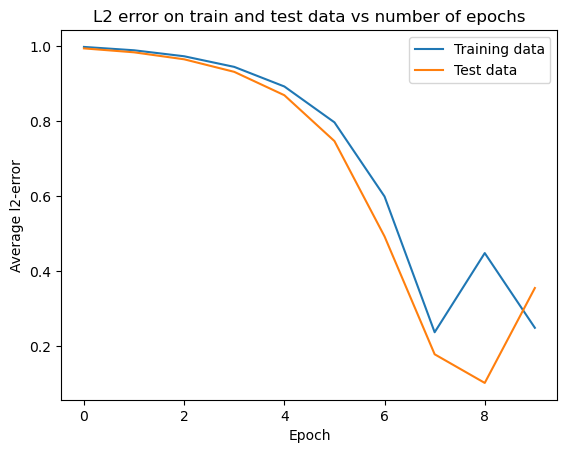

In [112]:
plt.plot(average_train_l2, label='Training data')
plt.plot(average_test_l2, label='Test data')
plt.legend()
plt.title("L2 error on train and test data vs number of epochs")
plt.ylabel("Average l2-error")
plt.xlabel("Epoch")

torch.Size([1, 20, 65, 97])
torch.Size([1, 65, 97, 128])
torch.Size([1, 65, 97, 1])
torch.Size([1, 20, 65, 97])
torch.Size([1, 65, 97, 128])
torch.Size([1, 65, 97, 1])
torch.Size([1, 20, 65, 97])
torch.Size([1, 65, 97, 128])
torch.Size([1, 65, 97, 1])
torch.Size([1, 20, 65, 97])
torch.Size([1, 65, 97, 128])
torch.Size([1, 65, 97, 1])
torch.Size([1, 20, 65, 97])
torch.Size([1, 65, 97, 128])
torch.Size([1, 65, 97, 1])
torch.Size([1, 20, 65, 97])
torch.Size([1, 65, 97, 128])
torch.Size([1, 65, 97, 1])
torch.Size([1, 20, 65, 97])
torch.Size([1, 65, 97, 128])
torch.Size([1, 65, 97, 1])
torch.Size([1, 20, 65, 97])
torch.Size([1, 65, 97, 128])
torch.Size([1, 65, 97, 1])
torch.Size([1, 20, 65, 97])
torch.Size([1, 65, 97, 128])
torch.Size([1, 65, 97, 1])
torch.Size([1, 20, 65, 97])
torch.Size([1, 65, 97, 128])
torch.Size([1, 65, 97, 1])
0.20690254867076874


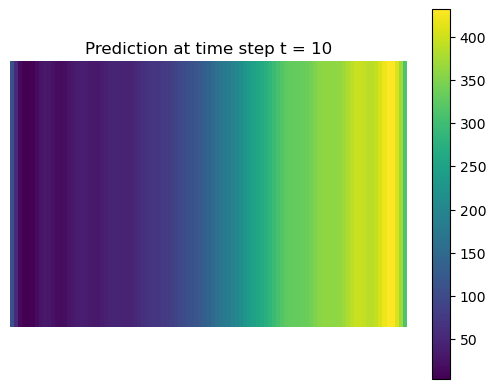

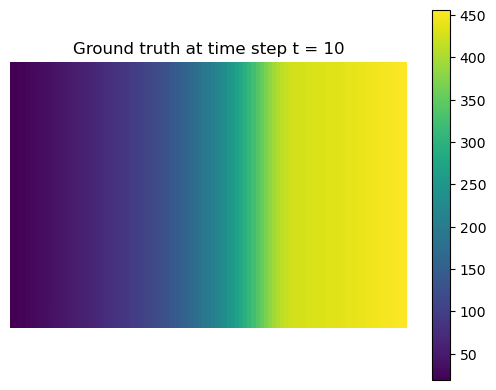

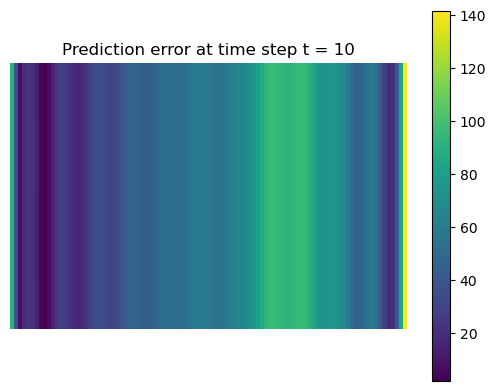

In [114]:
pred = torch.zeros(test_u.shape)
index = 0

# model = torch.load('model/ice_inverse_ep100')

first_outut = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0

        if index == 0:
            first_input = x.clone()
            first_output = y.clone()

        x, y = x.cuda(), y.cuda()

        out = model(x)
        # out = y_normalizer.decode(out)
        pred[index] = out

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)[:,::10]).item()
        # print(index, test_l2)
        index = index + 1


# Loss of first prediction
print(myloss(pred[0].view(1, -1)[:,::10], first_output.view(1,-1)[:,::10]).item())

# First prediction
Z = pred[0,:,:,0]
cp = plt.imshow(Z)
plt.axis('off')
plt.title("Prediction at time step t = 10")
plt.colorbar(cp) # Add a colorbar to a plot
plt.show()

# First actual output
Z = first_output[0,:,:,1]
cp = plt.imshow(Z)
plt.axis('off')
plt.title("Ground truth at time step t = 10")
plt.colorbar(cp) # Add a colorbar to a plot
plt.show()

# Error between first prediction and first output
Z = abs(pred[0,:,:,1] - first_output[0,:,:,0])
cp = plt.imshow(Z)
plt.axis('off')
plt.title("Prediction error at time step t = 10")
plt.colorbar(cp) # Add a colorbar to a plot
plt.show()